# Part 1: Data Analysis

## Import Libraries and Load data

In [1]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss
import torch.nn as nn

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

from python_speech_features import mfcc

root = './musicnet'

%matplotlib inline

import pretty_midi
import librosa, librosa.display


import IPython.display as ipd


The code for loading the data come from : https://github.com/jthickstun/pytorch_musicnet/blob/master/musicnet_module.ipynb

In [2]:
m = 128 ## second dimension of y : maximum number of note : quelquel note on entend dans cette extrait ?
k = 500
d = 4096

window = 16384
stride = 512
regions = 1 + (window - d)//stride


def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 0, 'pin_memory': True, 'worker_init_fn': worker_init}

train_set = musicnet.MusicNet(root=root, train=True, download=True,normalize =False, window=window)
test_set = musicnet.MusicNet(root=root, train=False,normalize =False, window=window, epoch_size=50000)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

## Check the cuda version and if it is available

In [3]:
print(torch.version.cuda)  
print(torch.cuda.device_count())
print(torch.cuda.is_available())

10.1
1
True


## Extracting MFCC features 

use of python_speech_features packages it uses interval tree in order to tag the frame. "This library was designed to allow tagging text and time intervals, where the intervals include the lower bound but not the upper bound."


In [4]:
with train_set, test_set:
    for i, (x, y) in enumerate(train_loader):
        print('shape of x : ',x.shape)
        print('shape of y : ',y.shape)
        mfcc_feat = mfcc(x.numpy()[0],samplerate =16384)
        print('mfcc feat : ' , mfcc_feat)
        print('shape of the mfcc feat : ', mfcc_feat.shape)
        break

shape of x :  torch.Size([100, 16384])
shape of y :  torch.Size([100, 128])
mfcc feat :  [[ -4.16207402  12.16807593   3.80306333 ...  -3.65736016   1.13918367
   -5.91501061]
 [ -4.21772145  12.63928199   2.5337815  ...  -6.7569228   -0.74398493
   -7.48830065]
 [ -4.20135499  16.27648066   0.89723995 ...  -9.35960601  -1.15897547
   -2.34742277]
 ...
 [ -5.06370209  22.26531407  -5.60372486 ... -10.16815339  -1.41347894
   -6.00771472]
 [ -4.96618649  24.39733214  -5.8458739  ... -13.92676788  -5.80501368
   -8.69753853]
 [ -5.15231372  25.53849316  -8.55696809 ... -21.35163271  -6.14499382
   -7.74405475]]
shape of the mfcc feat :  (99, 13)


x : 100 : batch size and 16384 size of the window

y : 100 : batch size and 128 number of frame

## Plot MFCC and spectogramm

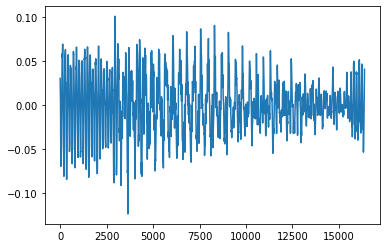

In [5]:
plt.plot(x.numpy()[10])
plt.show()

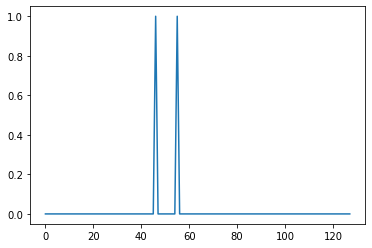

In [6]:
plt.plot(y.numpy()[10])
plt.show()

C:\Users\Samue\Anaconda3\envs\BML\lib\site-packages\librosa\core\spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


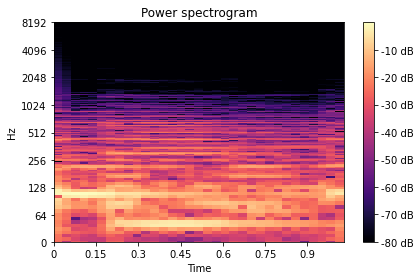

In [7]:
D = librosa.stft(x.numpy()[10])
sr = 16384
librosa.display.specshow(librosa.amplitude_to_db(D,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

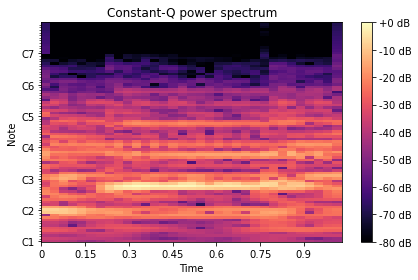

In [21]:
sr = 16384
C = np.abs(librosa.cqt(x.numpy()[10], sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

In [16]:
print(x.numpy()[10].shape)
print(C.shape)
print(D.shape)

(16384,)
(84, 33)
(1025, 33)


In [83]:
tab_C = np.array([np.abs(librosa.cqt(ele, sr=sr)) for ele in x.numpy()])
print(tab_C.shape)
tab_D = np.array([librosa.amplitude_to_db(librosa.stft(ele),ref=np.max) for ele in x.numpy()])
print(tab_D.shape)


(100, 84, 33)
(100, 1025, 33)


## Listen a sound sample

In [17]:
## listen the array file
rateB = 16384 #d
x_sum = np.sum(x.numpy(),axis=0)

# print(x_sum.size)

# ipd.Audio(x_sum, rate=rateB )
ipd.Audio(x.numpy()[10], rate=rateB) 

# Creation of the Model

## Define the model

In [57]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1, padding=1),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=1, stride=1, padding=1),
            nn.ReLU())
        
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(84*310+8, 50)
        self.fc2 = nn.Linear(50, 128)
        
    def forward(self, x):
        val = x[:,None,:,:]
        out = self.layer1(val)
        out = self.layer2(out)
        #print('avant : ',out.size())
        out = out.reshape(out.size(0), -1)
        #print('après : ',out.size())
        out = self.drop_out(out)
        #print('après dropout : ',out.size())
        out = self.fc1(out)
        #print('après fc1 : ',out.size())
        out = self.fc2(out)
        #print('après fc2: ',out.size())
        return out

## Use the model CNN - tab_C

In [62]:
## parameters from example
num_epochs = 5
num_classes = 10
learning_rate = 0.001
MODEL_STORE_PATH = './model'

model = ConvNet().float()

# Loss and optimizer
criterion = mse_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
# Train the model
actual_best_loss = 1000000

total_step = len(train_loader)
loss_list = []
acc_list = []
with train_set, test_set:
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            # Run the forward pass
            
            # x = Variable(x.cuda(), requires_grad=False)
            # y = Variable(y.cuda(), requires_grad=False)
            
            tab_C = np.array([np.abs(librosa.cqt(ele, sr=sr)) for ele in x.numpy()])
            tab_C = Variable(torch.from_numpy(tab_C).float(), requires_grad=False)
            #print(tab_C.shape)
                
            outputs = model(tab_C)
            
            #print('size of the output : ',outputs.size())
            #print('size of y : ',y.size())
            
            loss = criterion(outputs, y)*128/2.
            #print(loss)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()

            # Track the accuracy
            # total = labels.size(0)
            # _, predicted = torch.max(outputs.data, 1)
            # correct = (predicted == labels).sum().item()
            # acc_list.append(correct / total)

            if (i + 1) % 20 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        if(loss.item() < actual_best_loss):
            print("Model to save")
            torch.save(model.state_dict(), "CNN-CQT-binary.pt")
            actual_best_loss = loss.item()

Epoch [1/5], Step [20/1000], Loss: 5.5346%
Epoch [1/5], Step [40/1000], Loss: 2.2183%
Epoch [1/5], Step [60/1000], Loss: 1.6920%
Epoch [1/5], Step [80/1000], Loss: 1.7272%
Epoch [1/5], Step [100/1000], Loss: 1.6523%
Epoch [1/5], Step [120/1000], Loss: 1.5037%
Epoch [1/5], Step [140/1000], Loss: 1.6446%
Epoch [1/5], Step [160/1000], Loss: 1.6128%
Epoch [1/5], Step [180/1000], Loss: 1.6024%
Epoch [1/5], Step [200/1000], Loss: 1.5445%
Epoch [1/5], Step [220/1000], Loss: 1.5332%
Epoch [1/5], Step [240/1000], Loss: 1.4768%
Epoch [1/5], Step [260/1000], Loss: 1.6530%
Epoch [1/5], Step [280/1000], Loss: 1.4521%
Epoch [1/5], Step [300/1000], Loss: 1.6473%
Epoch [1/5], Step [320/1000], Loss: 1.4685%
Epoch [1/5], Step [340/1000], Loss: 1.4642%
Epoch [1/5], Step [360/1000], Loss: 1.6296%
Epoch [1/5], Step [380/1000], Loss: 1.5614%
Epoch [1/5], Step [400/1000], Loss: 1.4299%
Epoch [1/5], Step [420/1000], Loss: 1.4845%
Epoch [1/5], Step [440/1000], Loss: 1.4112%
Epoch [1/5], Step [460/1000], Loss: 

KeyboardInterrupt: 

In [64]:
print("Model to save")
torch.save(model.state_dict(), "CNN-CQT-binary.pt")
actual_best_loss = loss.item()

Model to save
